# Problem Description

The aim of the following code is to compute the Morozov regularization parameter $\alpha(\delta, g^\delta)$ that satisfies :

$$
|| A f_{\alpha(\delta, g^\delta)} - g^\delta || = \tau \delta, \quad \hbox{with $\tau > 1$ given}
$$

where 

$\bullet$ $A:  F \rightarrow G $ is a linear operator between two Hilbert spaces $F$ and $G$ with $\textbf{unbounded inverse}$.

$\bullet$ $g^\delta = A f + \xi $ is a noisy data ($f$ being the true solution that one aims to recover)

$\bullet$ $ f_\alpha$ is a regularized solution defined via the Tikhonov method

$$
(\mathcal{P_\alpha}) \qquad \qquad f_\alpha = \mathrm{argmin}_{f \in \mathrm{dom(J)}}  \quad || A f  - g^\delta||^2 + \alpha J(f),
$$

where $\alpha >0 $ is the regularization parameter, $J$ is a coercive lower semi-continuous and proper convex functional used for penalization.

$\bullet$ $\delta$ being an approximation of the noise level. That is $ || g^\delta - A f || \leq \delta$.


We recall that due to the unboundedness of the inverse of $A$, the equation 

$$
 A f = g
$$

which aims to find $f$ given $g$ is $\textbf{ill-posed}$.

Due to the ill-posedness, one needs a regularization method, and a crucial step of the regularization method is the choice of the regularization parameter.


Hence, in the sequel, we aims at computing the regularization parameter $\alpha(\delta, g^\delta)$ that satisfies :

$$
|| A f_{\alpha(\delta, g^\delta)} - g^\delta || = \tau \delta.
$$

Under mild assumption, we have that $\alpha(\delta, g^\delta)$ and $f_{$\alpha(\delta, g^\delta)}$ are the solution of the convex constrained optimization problem

$$
(\mathcal{Q}) \qquad \qquad \min_{\hbox{s.t. $||A f - g^\delta||^2 \leq \epsilon $}}  \quad J(f) , \qquad \hbox{where $\epsilon = (\tau \delta)^2$}.
$$

We define the Lagrangian function 

$$L(f,\lambda) = J(f) + \lambda(||A f - g^\delta||^2  - \epsilon) $$

Using Lagrange duality argument, under mild assumption, it is establish that computating $\alpha(\delta, g^\delta)$ and $f_{$\alpha(\delta, g^\delta)}$ can be done by solving the one-dimensional dual problem

$$
(\mathcal{D}) \qquad \qquad \max_{\lambda >0} \quad D(\lambda) , 
$$

where $D$ is the dual function defined by 

$$
D(\lambda) = \inf_{f \in dom(J)} \quad  L(f,\lambda) = \inf_{f \in dom(J)} J(f) + \lambda(||A f - g^\delta||^2  - \epsilon) .
$$

By definition of the dual function, we can readily see that evaluating the dual function is merely computing the regularized solution $f_\alpha$ with $\alpha = 1/\lambda$. 

More precisely, we have 
$$
D(\lambda) = J(f_{1/\lambda}) + \lambda(||A f_{1/\lambda} - g^\delta||^2  - \epsilon).
$$


Newt, we establish that the dual function $D$ is differentiable on $(0,\infty)$ with 

$$
D'(\lambda) = ||A f_{1/\lambda} - g^\delta||^2  - \epsilon.
$$


In summary, the compuation of regularization parameter $\alpha(\delta, g^\delta)$ together with the corresponding regularized solution $f_{\alpha(\delta, g^\delta)}$ can be done by solving the dual $(\mathcal{D})$.

In the following, we combine a Quasi-Newton method with Wolfe-Lemaréchal line-search algorithm for solving the dual problem $(\mathcal{D})$.

# Example Case: $F =  L^2(\Omega)$ and $J(f) = ||f||_{L^2}^2$.

In the sequel, we assume that the operator equation $A f = g $ is discretized into the matrix equation $M x = r $ 

$\textbf{Import of Libraries}$

In [6]:
import numpy as np
import scipy.linalg as sc_la
from numpy.linalg import norm
# from tkinter import * 
# from tkinter import messagebox

$\textbf{Wolfe-Lemarechal Line-search}$

In [7]:
def Stepsize_line_search(M,r,M_NE,M_t_r,epsilon_,lambda_k,d_k):
    """
    This function computes the step size alpha_k of the Quasi-Newton algorithm
    using 𝐖𝐨𝐥𝐟𝐞-𝐋𝐞𝐦𝐚𝐫é𝐜𝐡𝐚𝐥 𝐋𝐢𝐧𝐞-𝐬𝐞𝐚𝐫𝐜𝐡
    
    Walter Simo, April 2022
    """

    beta_1 = 1e-4
    beta_2 = 1-1e-4
    delta = 2
    alpha_g = 0
    alpha_d = 1e10
    alpha_0 = 1
    
    f_lambda_k = regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,1/lambda_k)
    D_lambda_k = norm(f_lambda_k)**2 + lambda_k*(norm( M @ f_lambda_k - r )**2 - epsilon_)
    
    lambda_k1   = lambda_k + alpha_0*d_k
    f_lambda_k1 = regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,1/lambda_k1)
    D_lambda_k1 = norm(f_lambda_k1)**2 + lambda_k1*(norm( M @ f_lambda_k1 - r )**2 - epsilon_)
    
    D_prime_lambda_k  = norm(M @ f_lambda_k - r)**2 - epsilon_
    D_prime_lambda_k1 = norm(M @ f_lambda_k1 - r)**2 - epsilon_
    
    t1 = D_lambda_k1  - D_lambda_k - alpha_0*d_k*beta_1*D_prime_lambda_k
                                           
    t2 = (D_prime_lambda_k1 - beta_2*D_prime_lambda_k)*d_k 
    
    k = 0
    alpha_k = alpha_0
    
    while t1<=0 or t2>0 :
        k = k +1
        if  t1<=0:
            alpha_d = alpha_k
            alpha_k = (alpha_d +alpha_g)/2
            
        if t2>0:
            alpha_g = alpha_k
            if alpha_d ==1e10:
                alpha_k = delta*alpha_k
            else:
                alpha_k = (alpha_d + alpha_g)/2
                
        lambda_k1   = lambda_k + alpha_k*d_k
        f_lambda_k1 = regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,1/lambda_k1)
        D_lambda_k1 = norm(f_lambda_k1)**2 + lambda_k1*(norm( M @ f_lambda_k1 - r )**2 - epsilon_)
        D_prime_lambda_k1 = norm(M @ f_lambda_k1 - r)**2 - epsilon_
        
        t1 = D_lambda_k1  - D_lambda_k - alpha_k*d_k*beta_1*D_prime_lambda_k
                                           
        t2 = (D_prime_lambda_k1 - beta_2*D_prime_lambda_k)*d_k 

        print("-- inner iteration i = %d,  -- alpha_k = %2.5E .\n" % (k,alpha_k))
        if abs(alpha_d-alpha_g)<1e-5:
            alpha_k = alpha_d
#             messagebox.showerror("Selection step size info", "ERROR: Value of stepsize apha_k not accurate !!")
#             messagebox.showwarning("Selection step size info", "WARNING: Value of stepsize apha_k not accurate !!")
            print(" WARNING: Value of stepsize apha_k not accurate !! ")
            break
            
    print("** Final stepsize alpha_k = %2.3E computed after %d iterations . ** \n" %(alpha_k,k))
    return alpha_k



$\textbf{Main program}$

In [8]:
def regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,alpha_):
    """
    This function computes the classical Tikhonov regularized solution with L_2 penalty term :
    
    f_alpha = argmin_f  ||A f -g ||_2^2 + alpha ||f||_2^2
    
    Here we assume that the operator equation A f =g  is discretized into the matrix equation
    M x = r where M is a matrix and r is vector.
    
    Here for this smooth optimization problem, we can use the first order optimality 
    condition 
    
    [ A^*A + alpha I ] f_alpha = A^*g
    
    to compute f_alpha
    
    Here, alpha >0 is the regularization parameter
    
    To reduce computation time, the argument are directly 
    M_NE  = M^t M and
    M_t_r = M^t r
    
    Walter Simo, April 2022
    """
    
    [mm,n]  = np.shape(M_NE)
    I_ = np.eye(n)
    
    return sc_la.solve(M_NE +  alpha_*I_,M_t_r)

def Selection_alpha_Morozov(M,r,lambda_0,tau,delta,tol):
    
    [mm,n]  = np.shape(M)
    M_t     = M.T
    M_NE    = M_t @ M
    M_t_r   = M_t @ r
    
    epsilon_ = (tau*delta)**2
    
    f_lambda_0       = regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,1/lambda_0)                    
    D_prime_lambda_0 = norm(M @ f_lambda_0 - r)**2 - epsilon_ 
    
    f_lambda_k       = f_lambda_0
    D_prime_lambda_k = D_prime_lambda_0
    H_k = 1 
    k = 0
    
    lambda_k = lambda_0
    List_lambda_k       = [lambda_0]
    List_D_prime_lambda_k = [abs(D_prime_lambda_k)]
    List_residu         = [np.sqrt(D_prime_lambda_0 + epsilon_) ]
    
    while abs(D_prime_lambda_k)>tol:
        
        k = k + 1
        
        print("----------------------------- Iteration %d , |D'(lambda_k)| = %2.5E -----------------------------\n" %(k,abs(D_prime_lambda_k)))
        
        d_k = - D_prime_lambda_k/H_k
        
        print(" Computation of the stepsize alpha_k for k = %d .... \n" % k)
        
        alpha_k  = Stepsize_line_search(M,r,M_NE,M_t_r,epsilon_,lambda_k,d_k) 
        
        lambda_k1 = lambda_k + alpha_k*d_k
        f_lambda_k1       = regulazed_sol_tikh_L2_penalization(M_NE,M_t_r,1/lambda_k1)
        D_prime_lambda_k1 = norm(M @ f_lambda_k1 - r)**2 - epsilon_
        
        H_k  =  (D_prime_lambda_k1 - D_prime_lambda_k)/(lambda_k1 - lambda_k)

        lambda_k         = lambda_k1
        f_lambda_k       = f_lambda_k1
        D_prime_lambda_k = D_prime_lambda_k1
        
        List_lambda_k.append(lambda_k)
        List_D_prime_lambda_k.append(abs(D_prime_lambda_k))
        List_residu.append(np.sqrt(D_prime_lambda_k + epsilon_))
        
    print(" Tolerance of %2.5E achieved ! \n " % tol)
    
    alpha_mor = 1/lambda_k
    error_ = abs(norm( M @ f_lambda_k - r)- tau*delta)
    
    print(" Number of main iterations done = %d.\n" % k)
    print(" Apha found = %2.3E \.n" % alpha_mor)
    print("|norm(M*D_lambda_k - r) - tau*delta| = %2.5E  \n." % error_)
    
    return alpha_mor,f_lambda_k,error_,List_D_prime_lambda_k,List_residu,List_lambda_k

$\textbf{Example}$

In [9]:
def Fred_int_eq(n):
    """ 
    Test problem: Fredholm integral equation of the ﬁrst kind.

    int_{[a,b]} K(s,t) f(t) dt = g(s) s in [c,d]
    The kernel is K(s,t) = exp(s cos(t)) 
    The solution is f(t) = sin(t)
    The bounds are [a,b] = [0, pi] and [c,d] = [0, pi/2]
    
    The discretization method is collocation with mid-point rule.
    n represents the number of collocation point
    
    Once the exact soltuion is constructed, and then the right-hand side
    b isdefined as b = A*x.

    Walter Simo, April 2022

    """""
    
    # Initialization
    a = 0
    b = np.pi
    c = 0
    d = np.pi/2
    
    m = int(n/2)
    
    h_t = (b-a)/n
    h_s = (d-c)/n
    
    t_ = np.arange(a + h_t/2,b,h_t)
    s_ = np.arange(c + h_s/2,d,h_s)
    
    # solution x
    x = np.sin(t_)
    
    # Matrix A
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            A[i,j] = h_t*np.exp(s_[i]*np.cos(t_[j]))

    b = A @ x
    
    return A,b,x

 ||noisy_r - r||/||r|| = = 9.42770E-06 

----------------------------- Iteration 1 , |D'(lambda_k)| = 4.10247E+01 -----------------------------

 Computation of the stepsize alpha_k for k = 1 .... 

-- inner iteration i = 1,  -- alpha_k = 2.00000E+00 .

-- inner iteration i = 2,  -- alpha_k = 1.75000E+00 .

-- inner iteration i = 3,  -- alpha_k = 1.87500E+00 .

-- inner iteration i = 4,  -- alpha_k = 1.84375E+00 .

-- inner iteration i = 5,  -- alpha_k = 1.83594E+00 .

-- inner iteration i = 6,  -- alpha_k = 1.83398E+00 .

-- inner iteration i = 7,  -- alpha_k = 1.83350E+00 .

-- inner iteration i = 8,  -- alpha_k = 1.83337E+00 .

-- inner iteration i = 9,  -- alpha_k = 1.83334E+00 .

-- inner iteration i = 10,  -- alpha_k = 1.83334E+00 .

-- inner iteration i = 11,  -- alpha_k = 1.83333E+00 .

** Final stepsize alpha_k = 1.833E+00 computed after 11 iterations . ** 

----------------------------- Iteration 2 , |D'(lambda_k)| = 5.77225E+00 -----------------------------

 Computation of 

** Final stepsize alpha_k = 1.000E+00 computed after 0 iterations . ** 

----------------------------- Iteration 31 , |D'(lambda_k)| = 6.94278E-07 -----------------------------

 Computation of the stepsize alpha_k for k = 31 .... 

** Final stepsize alpha_k = 1.000E+00 computed after 0 iterations . ** 

----------------------------- Iteration 32 , |D'(lambda_k)| = 4.64396E-07 -----------------------------

 Computation of the stepsize alpha_k for k = 32 .... 

** Final stepsize alpha_k = 1.000E+00 computed after 0 iterations . ** 

----------------------------- Iteration 33 , |D'(lambda_k)| = 3.25969E-07 -----------------------------

 Computation of the stepsize alpha_k for k = 33 .... 

** Final stepsize alpha_k = 1.000E+00 computed after 0 iterations . ** 

----------------------------- Iteration 34 , |D'(lambda_k)| = 2.23091E-07 -----------------------------

 Computation of the stepsize alpha_k for k = 34 .... 

** Final stepsize alpha_k = 1.000E+00 computed after 0 iterations . 

<IPython.core.display.Javascript object>


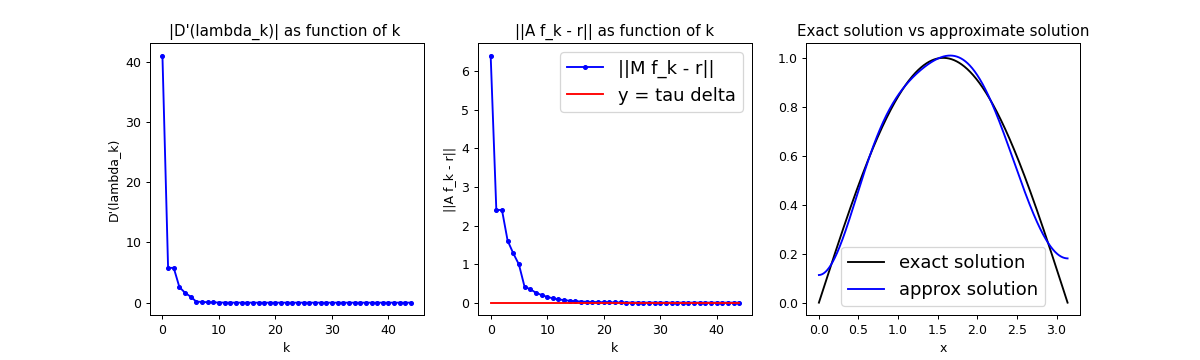

In [10]:
n_x = 700  # 700 x 700 Matrix equation

[M,r,x] = Fred_int_eq(n_x) 

perc_noise = 0.001
norm_r   = norm(r)
noise_   = (0.01*perc_noise*norm_r/np.sqrt(n_x)) *np.random.normal(loc = 0, scale = 1, size = (n_x))
noisy_r  =  r  + noise_

exact_rel_err = norm(noise_)/norm_r
print(" ||noisy_r - r||/||r|| = = %2.5E \n" % exact_rel_err )
lambda_0 = 1
tol = 1e-12
tau = 1.01
delta = norm(noise_)

[alpha_mor,f_alpha_mor,error_,List_D_prime_lambda_k,List_residu,List_lambda_k] = Selection_alpha_Morozov(M,noisy_r,lambda_0,tau,delta,tol)
nb_iteration = len(List_lambda_k) 

import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook

fig_ = plt.figure(figsize=plt.figaspect(0.3))
ax = fig_.add_subplot(1, 3, 1)
x_  = np.arange(0,nb_iteration,1)
ax.plot(x_,List_D_prime_lambda_k,'b.-',label=" |D'(lambda_k)| as function of k ")
ax.set_xlabel('k')
ax.set_ylabel("D'(lambda_k)")
ax.set_title("|D'(lambda_k)| as function of k ")

ax = fig_.add_subplot(1, 3, 2)
ax.plot(x_,List_residu,'b.-',label = '||M f_k - r||')
ax.plot(x_,tau*delta*np.ones(nb_iteration),'r',label = 'y = tau delta')
ax.set_xlabel('k')
ax.set_ylabel("||A f_k - r||")
ax.set_title("||A f_k - r|| as function of k")
legend = ax.legend(loc='upper right', shadow=False, fontsize='x-large')

h  = np.pi/n_x 
t_ = np.arange(h/2,np.pi,h)

ax = fig_.add_subplot(1, 3, 3)
ax.plot(t_,x,'k',label= 'exact solution')
ax.plot(t_,f_alpha_mor,'b',label= 'approx solution')
ax.set_xlabel('x')
ax.set_title("Exact solution vs approximate solution")
legend = ax.legend(loc='lower center', shadow=False, fontsize='x-large')
plt.show()